# **Universal Approximation**

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import torch

from tqdm import tqdm

In [2]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

Using device: cpu



In [3]:
#While working with GPUs
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Model


In [4]:
def parameter_initialize(hidden): 
    '''Initialize parameters W and b'''
    #Input Layer to Hidden 
    W_1 = torch.randn(hidden,1, dtype = dtype, device=device) - 0.5
    b_1 = torch.randn(hidden,1, dtype = dtype, device=device) - 0.5
    
    #Hidden Layer to output
    W_2 = torch.randn(1,hidden, dtype = dtype, device=device) - 0.5
    b_2 = torch.randn(1,1, dtype = dtype, device=device) - 0.5
    return W_1, b_1, W_2, b_2

In [5]:
def forward(a_0, W_1, W_2, b_1, b_2): 
    '''Forward Propagation Function'''
    n_1 = W_1.mm(a_0) + b_1
    a_1 = []

    for i in range(n_1.shape[0]):
          a_1.append(float(1)/(1+math.exp(-n_1[i])))

    a_1 = torch.tensor(a_1, device=device).float().reshape(-1,1)

    n_2 = W_2.mm(a_1) + b_2
    a_2 = n_2

    return a_2,n_2,a_1,n_1

def backward(error, a_1, W_2): 
    '''Backpropagation Function'''
    s_2 = -2*1*error
    F_1 = []
    for i in range(a_1.shape[0]):
        F_1.append((1-a_1[i][0])*a_1[i][0])
    F_1 = torch.tensor(F_1, device=device).float().reshape(-1)
    F_1 = torch.diag(F_1)

    s_1 = F_1.mm(W_2.t())
    s_1 = s_1.mm(s_2)
    return s_1, s_2

def Update(W_1, W_2, b_1, b_2, lr, s_1, s_2, a_1, a_0 ): 
    '''Weight and Bias Updation'''
    W_2_new = W_2 - lr*s_2.mm(a_1.t())
    b_2_new = b_2 - lr*s_2
    W_1_new = W_1 - lr*s_1.mm(a_0.t())
    b_1_new = b_1 - lr*s_1
    return W_2_new, W_1_new, b_2_new, b_1_new

# Plotting Functions 

In [6]:
def plot_error(lr,s,epoch,error):
    plt.figure(figsize = (10,5))
    plt.plot(epoch, error, c='blue', label=str(lr), alpha = 0.3)
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared error')
    plt.legend(loc='best')
    plt.title('Mean Squared Error / {} neurons'.format(s))
    plt.show()

def plot_function(input,output):
    plt.figure(figsize = (10,5))
    input = input.numpy()
    plt.plot(input,output, c='green', label='function')
    plt.xlabel('data')
    plt.ylabel('Output')
    plt.legend(loc='best')

def plot_network(W_2, W_1, b_2, b_1, input, epochs):
    output_list = []
    for x in input:
        x = x.reshape(1,1)
        output, n_2, a_1, n_1 = forward(x,W_1,W_2,b_1,b_2)
        output = output[0]
        output_list.append(output)
    input = input.numpy()
    plt.plot(input,output_list,c='orange',label='Network')
    plt.title('Function vs Network after {} epochs'.format(epochs))
    plt.grid(True)
    plt.legend(loc='best')
    plt.show()

# Function to approximate
#### 1. Cosine Function

In [7]:
data = torch.linspace(-3,3,100,dtype = dtype, device=device).reshape(100,1)

In [8]:
def approximate_function_1(a_0): 
    return math.cos(a_0)

In [9]:
var = []
for x in data.reshape(-1):
    var.append(approximate_function_1(x))

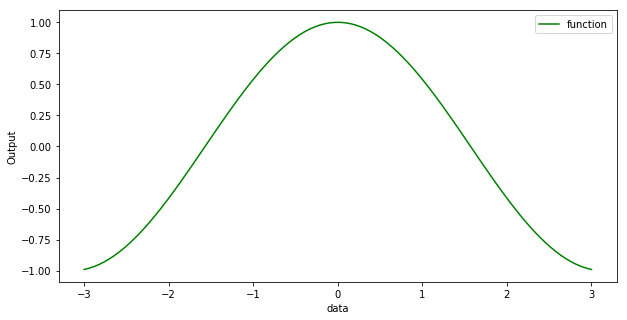

In [10]:
plot_function(data,var)
plt.savefig('images/cosine.jpeg')

#### 2. Sine Function

In [11]:
def approximate_function_2(a_0): 
    return math.sin(a_0)

In [12]:
var_1 = []
for x in data.reshape(-1):
    var_1.append(approximate_function_2(x))

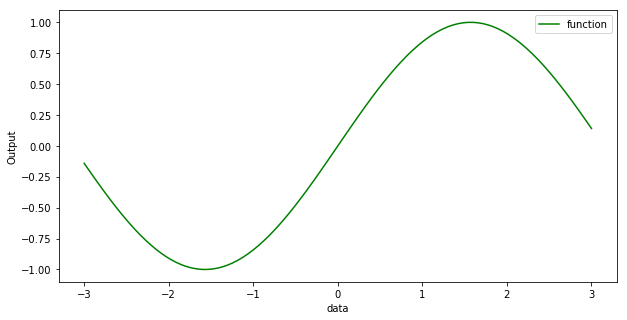

In [13]:
plot_function(data,var_1)
plt.savefig('images/sine.jpeg')

# **Training**

In [14]:
epochs=1000
s = 100
lr = 0.01

#### 1. Cosine Function Approximation

In [15]:
error_list = []
epoch_list = []

W_1, b_1, W_2, b_2 = parameter_initialize(s)  # Parameter initialize

for epoch in tqdm(range(epochs)):
    epoch_list.append(epoch)
    p_1 = torch.linspace(-3,3,100,dtype = dtype, device=device).reshape(100,1)
    sum = 0
    for iter in range(p_1.shape[0]):

        a_0 = p_1[iter][0].reshape(1, 1)

        output, n_2, a_1, n_1 = forward(a_0, W_1, W_2, b_1, b_2)
        target = approximate_function_1(a_0)
        error = target - output
        square_error = (error.reshape(-1)[0]) * (error.reshape(-1)[0])
        sum += square_error
        s_1, s_2 = backward(error, a_1, W_2)
        W_2, W_1, b_2, b_1 = Update(W_1, W_2, b_1, b_2, lr, s_1, s_2, a_1, a_0)
    mean_square_error = sum/p_1.shape[0]
    #print("Epoch {} --> MSE: {}".format(epoch + 1,mean_square_error))
    error_list.append(mean_square_error)

y = []
for x in p_1.reshape(-1):
    y.append(approximate_function_1(x))

100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]


In [16]:
print('Final MSE : {}'.format(mean_square_error))

Final MSE : 0.0004298277199268341


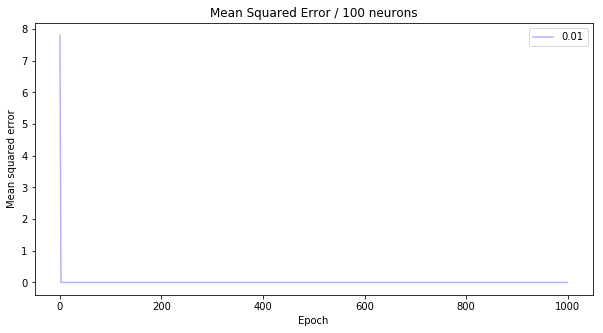

In [17]:
plot_error(lr, s, epoch_list, error_list)

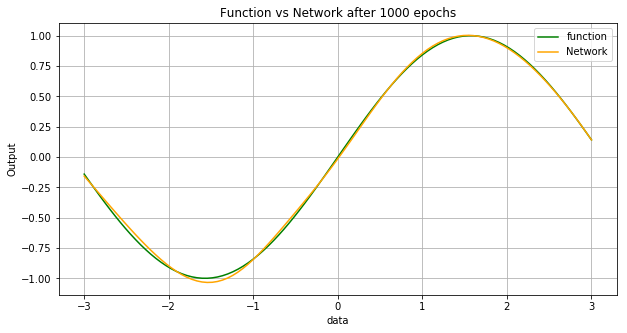

<Figure size 432x288 with 0 Axes>

In [23]:
plot_function(p_1,y)
plot_network(W_2, W_1, b_2, b_1, p_1, epochs)
plt.savefig('images/approx_cosine.jpeg')

### Sine Function Approximation

In [19]:
error_list = []
epoch_list = []

W_1, b_1, W_2, b_2 = parameter_initialize(s)  # Parameter initialize

for epoch in tqdm(range(epochs)):
    epoch_list.append(epoch)
    p_2 = torch.linspace(-3,3,100,dtype = dtype, device=device).reshape(100,1)
    sum = 0
    for iter in range(p_2.shape[0]):

        a_0 = p_2[iter][0].reshape(1, 1)

        output, n_2, a_1, n_1 = forward(a_0, W_1, W_2, b_1, b_2)
        target = approximate_function_2(a_0)
        error = target - output
        square_error = (error.reshape(-1)[0]) * (error.reshape(-1)[0])
        sum += square_error

        s_1, s_2 = backward(error, a_1, W_2)
        W_2, W_1, b_2, b_1 = Update(W_1, W_2, b_1, b_2, lr, s_1, s_2, a_1, a_0)
    mean_square_error = sum/p_2.shape[0]
    #print("Epoch {} --> MSE: {}".format(epoch + 1,mean_square_error))
    error_list.append(mean_square_error)

y = []
for x in p_2.reshape(-1):
    y.append(approximate_function_2(x))

100%|██████████| 1000/1000 [04:57<00:00,  3.36it/s]


In [20]:
print('Final MSE : {}'.format(mean_square_error))

Final MSE : 3.1874311389401555e-05


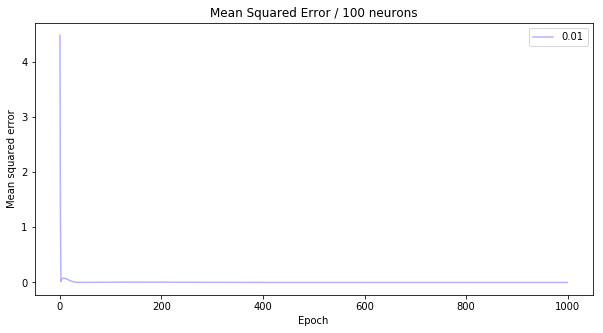

In [21]:
plot_error(lr, s, epoch_list, error_list)

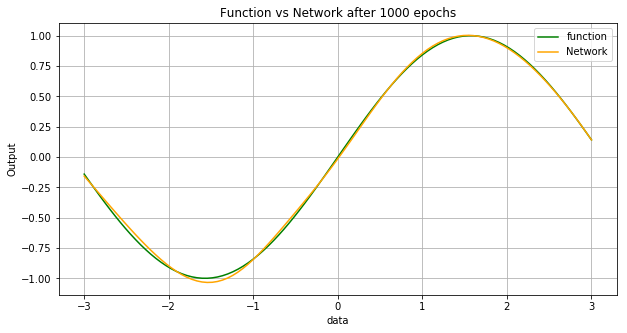

<Figure size 432x288 with 0 Axes>

In [22]:
plot_function(p_2,y)
plot_network(W_2, W_1, b_2, b_1, p_2, epochs)
plt.savefig('images/approx_sine.jpeg')

The End, Thank-you!